In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import torch
import seaborn as sns
import ristretto.activations as ra
import ristretto.models as rm
import ristretto.utils as ru

# Importing the dataset for experiments
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

#Some useful imports
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

In [3]:
# We are taking our custom model creator to make a model with custom features 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# We are taking our custom model creator to make a model with custom features
def make_mlp_models(alpha = 0, nb_neurons = 200, nb_layers=3, regularizer = torch.nn.Identity(), device = device ):
    layers = [nb_neurons]*nb_layers
    return rm.FullyConnected(activation=lambda: ra.ReLU(alpha), reg=lambda: regularizer , hidden_dims=layers, seed=None)
    
    
# We copy the parameters of the first model to the second model to make sure that they are the same  
def copy_params(net1, net2):
    params1 = net1.named_parameters()
    params2 = net2.named_parameters()

    dict_params2 = dict(params2)

    for name, param in params1:
        if name in dict_params2:
            dict_params2[name].data.copy_(param.data)
           
           
# We are making a function to build the models with the given parameters we will use it in each experiment           
def build_models(nb_neurons=512, nb_hidden_layers=2, precision=32, device = device):
    net1 = make_mlp_models( 0, nb_neurons, nb_hidden_layers, device = device).to(device)
    net2 = make_mlp_models( 1, nb_neurons, nb_hidden_layers, device = device).to(device)

    copy_params(net1, net2)
    
    for net in [net1, net2]:
        
        if precision == 16:
            net.half()
        if precision == 64:
            net.double()

    return net1, net2


In [7]:
# Number of experiments to run 
nb_experiments = 100 


#Load data to run experiments
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256)


In [5]:
df = pd.DataFrame(columns=["precision", "count", "nb_layers"])

# This experiment iterates through the number of layers and the precisions with a fixed number of neurons
nb_neurons = 32
batch_size = 256


for precision in tqdm([16,32,64], desc='precision'): # We iterate through the precisions
    for nb_layers in tqdm([1,2,3,5,6], desc='number of layers', leave=False): # We iterate through the number of layers
        count = 0
        
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False): # This just runs the experimets nb_experiments times
            # In this part we dont do the training, we just build the models and check if the gradients are the same
            # No optimization is done, is just a volume estimation.
            # each experiment does one forward pass and one backward pass
            
            (net1, net2) = build_models(nb_neurons, nb_layers, precision, device)
            
            for x, y in train_loader:
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    break#x = x.double()
                y = y.to(device)
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                
                if (net1.sequence[0].weight.grad - net2.sequence[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
                
        df = df.append({"precision": precision,
                        "nb_layers": nb_layers,
                        "count": count}, ignore_index=True)
        
        
df.to_csv("volume_estimation_by_number_of_layers_MNIST.csv")

precision:   0%|          | 0/3 [00:00<?, ?it/s]

nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


nb_layers:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\1375163056.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


In [52]:
#In case we want to relabel the plots
df = pd.read_csv("volume_estimation_by_number_of_layers_MNIST.csv")

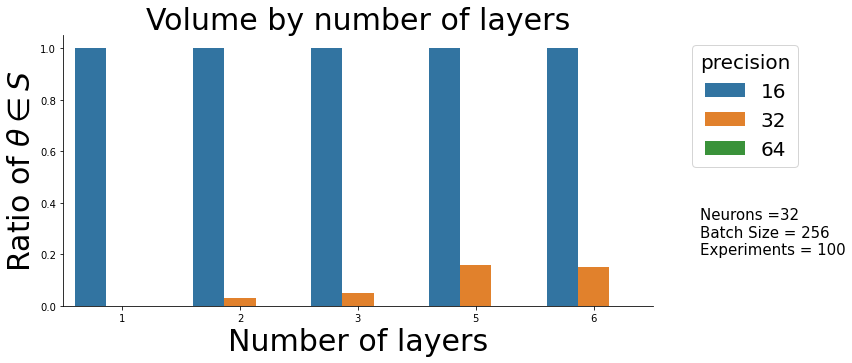

In [53]:

df['ratio'] = df['count'] / nb_experiments
sns.catplot(x = "nb_layers",       
            y = "ratio",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=False
            )

plt.legend(title='precision', fontsize='20', title_fontsize='20', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of layers', fontsize='30');
plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='30');
plt.yticks(fontsize='10');
plt.xticks(fontsize='10');
plt.title("Volume by number of layers", fontsize='30')
plt.text(4.9,.2, "Neurons =32\nBatch Size = 256\nExperiments = 100", fontsize='15');
plt.savefig('layers.png')

In [14]:
df = pd.DataFrame(columns=["precision", "count", "nb_layers"])

# This experiment iterates through the number of neurons and the precisions with a fixed number of layers

nb_layers = 4
batch_size = 256

for precision in tqdm([16,32, 64], desc='precision'):
    for nb_neurons in tqdm([4,8,16,32,64], desc='nb_neurons', leave=False):
        count = 0
        
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            
            (net1, net2) = build_models(nb_neurons, nb_layers, precision, device)
            
            for x, y in train_loader:
                
                if precision == 16:
                    x = x.type(torch.HalfTensor)
                if precision == 64:
                    x = x.type(torch.DoubleTensor)
                    
                x = x.to(device)
                y = y.to(device)
                same = True
                
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                
                if (net1.sequence[0].weight.grad - net2.sequence[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
                
        df = df.append({"precision": precision,
                        "nb_neurons": nb_neurons,
                        "count": count}, ignore_index=True)


df.to_csv("volume_estimation_by_number_of_neurons_MNIST.csv")

precision:   0%|          | 0/3 [00:00<?, ?it/s]

nb_neurons:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


nb_neurons:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


nb_neurons:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_5596\2725346550.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


In [54]:
#In case we want to relabel
df = pd.read_csv("volume_estimation_by_number_of_neurons_MNIST.csv")

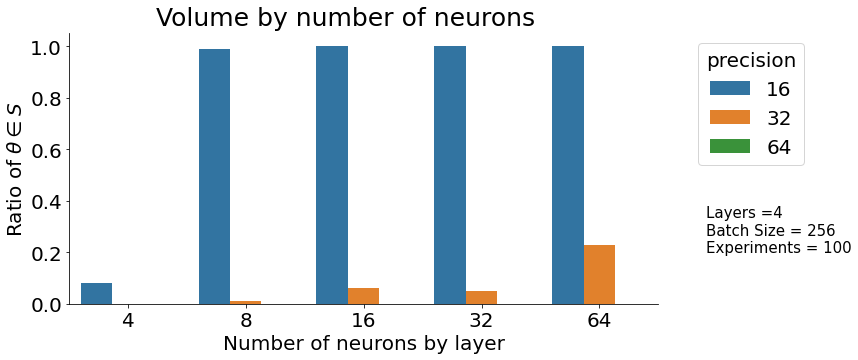

In [55]:
df['ratio'] = df['count'] / nb_experiments
df = df.astype({"nb_neurons": int})
sns.catplot(x = "nb_neurons",       
            y = "ratio",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=False
            )

plt.legend(title='precision', fontsize='20', title_fontsize='20', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of neurons by layer', fontsize='20');
plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='20');
plt.suptitle("Volume by number of neurons", fontsize='25', y=1.05)
plt.yticks(fontsize='20');
plt.xticks(fontsize='20');
plt.text(4.9,.2, "Layers =4\nBatch Size = 256 \nExperiments = 100", fontsize='15');
plt.savefig('neurons.png')

In [5]:
# This experiment is done with different batch sizes and precisions with a fixed number of layers and neurons
df = pd.DataFrame(columns=["precision", "count", "nb_layers"])

nb_layers = 3
nb_neurons = 32

for precision in tqdm([16,32,64], desc='precision'):
    for batch_size in tqdm([16, 32, 64, 128, 256], desc='batch_size', leave=False):
        count = 0
        
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
        
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            
            (net1, net2) = build_models(nb_neurons, nb_layers, precision, device)
            
            for x, y in train_loader:
                
                if precision == 16:
                    x = x.type(torch.HalfTensor)
                if precision == 64:
                    x = x.type(torch.DoubleTensor)
                
                x = x.to(device)
                y = y.to(device)
                
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                
                if (net1.sequence[0].weight.grad - net2.sequence[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
                
        df = df.append({"precision": precision,
                        "batch_size": batch_size,
                        "count": count}, ignore_index=True)

df.to_csv("volume_estimation_by_batch_size_MNIST.csv")

precision:   0%|          | 0/3 [00:00<?, ?it/s]

batch_size:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


batch_size:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


batch_size:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_704\2002191208.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


In [48]:
df = pd.read_csv("volume_estimation_by_batch_size_MNIST.csv")

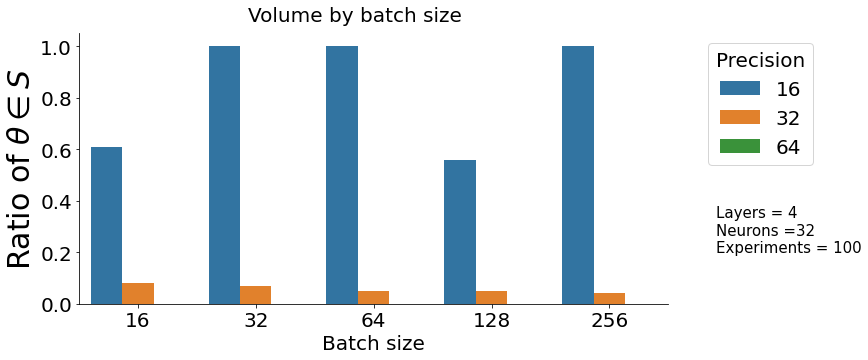

In [49]:
df['ratio'] = df['count'] / nb_experiments
df = df.astype({"batch_size": int})

sns.catplot(x = "batch_size",       
            y = "ratio",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=False
            )

plt.legend(title='Precision', fontsize='20', title_fontsize='20', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle("Volume by batch size", fontsize='20', y=1.05)
plt.xlabel('Batch size', fontsize='20');
plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='30');
plt.yticks(fontsize='20');
plt.xticks(fontsize='20');
plt.text(4.9,.2, "Layers = 4\nNeurons =32 \nExperiments = 100", fontsize='15');
plt.savefig('Batches.png')

it ran 197 minutes with NVIDIA GeForce RTX 3060 GPU

In [5]:
# Varying the size of the dataset

df = pd.DataFrame(columns=["precision", "count", "nb_layers"])

nb_layers = 3
nb_neurons = 32
batch_size = 64
samples =[10000,20000,40000,50000,60000]

for precision in tqdm([16,32,64], desc='precision'):
    for sample_size in tqdm(samples, desc='Number of samples', leave=False):
        count = 0
        
        train_data_new = torch.utils.data.Subset(train_data, np.random.randint(0, int(len(train_data)), (int(sample_size),)))  
        train_loader = torch.utils.data.DataLoader(train_data_new, batch_size=batch_size)
        
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            
            (net1, net2) = build_models(nb_neurons, nb_layers, precision, device)
            
            for x, y in train_loader:
                
                if precision == 16:
                    x = x.type(torch.HalfTensor)
                if precision == 64:
                    x = x.type(torch.DoubleTensor)
                
                x = x.to(device)
                y = y.to(device)
                
                same = True
                y1 = net1(x.view(-1, 28 * 28))
                y2 = net2(x.view(-1, 28 * 28))
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                
                if (net1.sequence[0].weight.grad - net2.sequence[0].weight.grad).abs().sum() != 0:
                    count += 1
                    break
                
        df = df.append({"precision": precision,
                        "sample_size": sample_size,
                        "count": count}, ignore_index=True)

df.to_csv("volume_estimation_by_sample_size_MNIST.csv")

precision:   0%|          | 0/3 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


Number of samples:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


Number of samples:   0%|          | 0/5 [00:00<?, ?it/s]

run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


run:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\hecma\AppData\Local\Temp\ipykernel_24184\844525202.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"precision": precision,


took 86 min to run on NVIDIA GeForce RTX 3060 GPU

In [50]:
#In case we want to relabel
df = pd.read_csv("volume_estimation_by_sample_size_MNIST.csv")

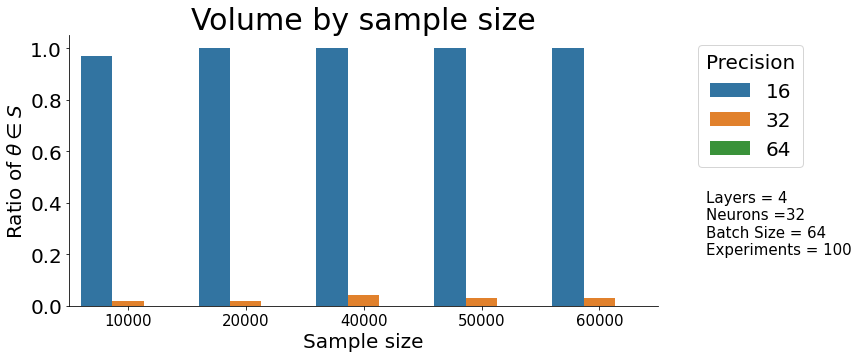

In [51]:
df['ratio'] = df['count'] / nb_experiments
df = df.astype({"sample_size": int})

sns.catplot(x = "sample_size",       
            y = "ratio",       
            hue = "precision",                  
            data = df,     
            kind = "bar",
            height=4.5, aspect=2,
            legend=False
            )

plt.legend(title='Precision', fontsize='20', title_fontsize='20', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Volume by sample size', fontsize='30')
plt.xlabel('Sample size', fontsize='20');
plt.ylabel('Ratio of ' + r'$\theta \in S$', fontsize='20');
plt.yticks(fontsize='20');
plt.xticks(fontsize='15');
plt.text(4.9,.2, "Layers = 4\nNeurons =32\nBatch Size = 64\nExperiments = 100", fontsize='15');
plt.savefig('sample size.png')  